<a href="https://colab.research.google.com/github/gopinathak-geek/novozymes-enzyme-stability-prediction/blob/main/NovoModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary libraries 

In [279]:
import numpy as np
import pandas as pd
import random
from scipy import stats
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

Load the source data (CSV) files from Github

In [280]:
train_csv = "https://raw.githubusercontent.com/gopinathak-geek/novozymes-enzyme-stability-prediction/main/data/train.csv"
train_updates_csv = "https://raw.githubusercontent.com/gopinathak-geek/novozymes-enzyme-stability-prediction/main/data/train_updates_20220929.csv"
test_csv = "https://raw.githubusercontent.com/gopinathak-geek/novozymes-enzyme-stability-prediction/main/data/test.csv"

Read the Loaded CSV files

In [281]:
train_df = pd.read_csv(train_csv)
train_updates_df = pd.read_csv(train_updates_csv)
test_df = pd.read_csv(test_csv)
test_seq_id = test_df['seq_id']

Adjust the train data with respect to the corrections in the train_updates data
for more information: [see here](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251)

In [282]:
# seq_id of the row to be deleted in the train file
seq_ids_to_delete = train_updates_df[train_updates_df["pH"].isnull()]["seq_id"].values

# seq_id of the row to be replaced in the train file
seq_ids_to_replace = train_updates_df[train_updates_df["pH"].notnull()]["seq_id"].values

#drop the train rows
train_df.drop(train_df[train_df.seq_id.isin(seq_ids_to_delete)].index, inplace=True)

#replace the train rows with train update row
train_df.loc[train_df.seq_id.isin(seq_ids_to_replace), ["pH", "tm"]] = train_updates_df[train_updates_df.seq_id.isin(seq_ids_to_replace)][["pH", "tm"]].values

**EDA**

In [283]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28981 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            28981 non-null  int64  
 1   protein_sequence  28981 non-null  object 
 2   pH                28695 non-null  float64
 3   data_source       28001 non-null  object 
 4   tm                28981 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.3+ MB


In [284]:
# some of the PH values are null so delete those rows
null_seq_ids = train_df[train_df["pH"].isnull()]["seq_id"].values
train_df.drop(train_df[train_df.seq_id.isin(null_seq_ids)].index, inplace=True)

In [285]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28695 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            28695 non-null  int64  
 1   protein_sequence  28695 non-null  object 
 2   pH                28695 non-null  float64
 3   data_source       27727 non-null  object 
 4   tm                28695 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.3+ MB


In [286]:
train_df.describe()[['pH', 'tm']].transpose()

,count,mean,std,min,25%,50%,75%,max
pH,28695.0,6.872467,0.793184,1.99,7.0,7.0,7.0,11.0
tm,28695.0,51.385604,12.076609,25.10,43.7,48.8,54.6,130.0


In [287]:
# Get the unique values of PH in train data 
train_df.pH.unique()

array([ 7.  ,  7.5 ,  5.5 ,  6.2 ,  6.3 ,  8.5 ,  3.  ,  6.8 ,  6.4 ,
        6.6 ,  6.7 ,  6.5 ,  4.5 ,  7.3 ,  5.  ,  6.  ,  4.  ,  3.5 ,
        7.4 ,  4.2 ,  5.1 ,  7.1 ,  3.2 ,  2.5 ,  2.  ,  5.2 ,  7.2 ,
        8.  ,  5.8 ,  7.8 ,  9.  ,  7.7 ,  7.6 , 10.  ,  8.2 ,  2.7 ,
        2.8 ,  2.9 ,  3.1 ,  3.14,  2.53,  2.3 ,  2.2 ,  2.81,  8.25,
        9.9 ,  9.5 , 10.4 ,  9.08,  3.7 ,  4.6 ,  4.4 ,  3.6 ,  5.4 ,
        5.35,  5.38,  5.9 ,  5.28,  5.42,  6.1 ,  9.7 ,  8.6 ,  6.78,
        5.3 ,  5.31,  3.02,  6.9 ,  5.7 ,  4.9 ,  4.3 ,  5.45,  3.01,
        3.3 ,  3.8 ,  4.8 ,  2.4 ,  2.84,  2.34,  4.7 ,  2.1 ,  3.9 ,
        2.02,  2.83,  2.03,  2.86,  1.99,  3.16,  2.94,  9.75,  3.15,
        3.07,  3.04,  3.25,  3.21,  2.98,  3.19,  4.1 ,  5.6 ,  3.75,
        4.75,  4.25,  9.6 , 11.  , 10.3 ])

In [288]:
# Remove rows of ph less than 6 or greater than 8
train_df.drop(train_df[train_df.pH > 8 ].index, inplace=True)
train_df.drop(train_df[train_df.pH < 6 ].index, inplace=True)
train_df.pH.unique()

array([7.  , 7.5 , 6.2 , 6.3 , 6.8 , 6.4 , 6.6 , 6.7 , 6.5 , 7.3 , 6.  ,
       7.4 , 7.1 , 7.2 , 8.  , 7.8 , 7.7 , 7.6 , 6.1 , 6.78, 6.9 ])

In [289]:
train_df.describe()[['pH', 'tm']].transpose()

,count,mean,std,min,25%,50%,75%,max
pH,26997.0,7.018893,0.161061,6.0,7.0,7.0,7.0,8.0
tm,26997.0,51.239497,12.030520,25.1,43.6,48.6,54.2,130.0


In [290]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26997 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            26997 non-null  int64  
 1   protein_sequence  26997 non-null  object 
 2   pH                26997 non-null  float64
 3   data_source       26521 non-null  object 
 4   tm                26997 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [291]:
def getMolecularWeight(aminoacid):
  if aminoacid == "A": return 89
  elif aminoacid == "R": return 174
  elif aminoacid == "N": return 132
  elif aminoacid == "D": return 133
  elif aminoacid == "B": return 133
  elif aminoacid == "C": return 121
  elif aminoacid == "Q": return 146
  elif aminoacid == "E": return 147
  elif aminoacid == "Z": return 147
  elif aminoacid == "G": return 75
  elif aminoacid == "H": return 155
  elif aminoacid == "I": return 131
  elif aminoacid == "L": return 131
  elif aminoacid == "K": return 146
  elif aminoacid == "M": return 149
  elif aminoacid == "F": return 165
  elif aminoacid == "P": return 115
  elif aminoacid == "S": return 105
  elif aminoacid == "T": return 119
  elif aminoacid == "W": return 204
  elif aminoacid == "Y": return 181
  elif aminoacid == "V": return 117
  else: return 0

In [292]:
def proteinSequenceToAmioAcidMolecularWeightWithPhAndLabel(data):
  amionAcidSequence = []
  img = []
  label = []
  for index, row in data.iterrows():
    ph = row['pH']
    tm = row['tm']
    molecularWeightOfAminoAcidInSequence = []
    pHofProteinSequence = []
    for aminoacid in (row['protein_sequence']):
      molecularWeight = getMolecularWeight(aminoacid)
      molecularWeightOfAminoAcidInSequence.append(molecularWeight/110)
      pHofProteinSequence.append(ph)
    a = np.array([molecularWeightOfAminoAcidInSequence,pHofProteinSequence])
    a = a[None, :]
    img.append(a)
    label.append(tm)
  return [img, label]

In [293]:
def proteinSequenceToAmioAcidMolecularWeightWithPh(data):
  amionAcidSequence = []
  img = []
  for index, row in data.iterrows():
    ph = row['pH']
    molecularWeightOfAminoAcidInSequence = []
    pHofProteinSequence = []
    for aminoacid in (row['protein_sequence']):
      molecularWeight = getMolecularWeight(aminoacid)
      molecularWeightOfAminoAcidInSequence.append(molecularWeight/110)
      pHofProteinSequence.append(ph)
    a = np.array([molecularWeightOfAminoAcidInSequence,pHofProteinSequence])
    a = a[None, :]
    img.append(a)
  return img

In [294]:
def getAvgLengthOfProteinSequence(data):
  proteinSequenceLength = []
  for index, row in data.iterrows():
    protein_sequence = row['protein_sequence']
    proteinSequenceLength.append(len(protein_sequence))
  return np.mean(proteinSequenceLength)

avgLength = getAvgLengthOfProteinSequence(train_df)
avgLength 


467.1845760640071

In [295]:
train_img, train_label = proteinSequenceToAmioAcidMolecularWeightWithPhAndLabel(train_df)
test_img = proteinSequenceToAmioAcidMolecularWeightWithPh(test_df)

In [296]:
import torchvision.transforms as T
from PIL import Image

preprocess = T.Compose([
   T.Resize((2,467)),
])

def change_shape(data):
    torch_img = []
    for im in (data):
        im = torch.FloatTensor(im)
        #transform = T.ToPILImage()
        #img = transform(im)
        x = preprocess(im)
        x = x.cpu().detach().numpy()
        torch_img.append(x)
    return torch_img

In [297]:
train_img = change_shape(train_img)
test_img = change_shape(test_img)

In [298]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [299]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [300]:
train_data = TrainData(torch.FloatTensor(train_img), torch.FloatTensor(train_label))
test_data = TestData(torch.FloatTensor(test_img))

In [301]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
training_data, validation_data = torch.utils.data.random_split(train_data, [train_size, val_size])

In [302]:
BATCH_SIZE = 64
training_loader = DataLoader(dataset=training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [303]:
class NovoNet(nn.Module):
    def __init__(self, name='Novonet'):
        super(NovoNet, self).__init__()
        if name:
            self.name = name
        self.conv1 = nn.Conv2d(1, 2, (2,3), stride=(2, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d((2, 3), stride=(2, 2), padding=(1,0))
        self.conv2 = nn.Conv2d(2, 6, (2,3), stride=(2, 1), padding=(1, 1))
        self.fc1 = nn.Linear(6 * 2 * 116, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        
        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 2 * 116)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [304]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [305]:
net = NovoNet(name='Novonet')
net.to(device)

Novonet: total params: 177501


NovoNet(
  (conv1): Conv2d(1, 2, kernel_size=(2, 3), stride=(2, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 3), stride=(2, 2), padding=(1, 0), dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 6, kernel_size=(2, 3), stride=(2, 1), padding=(1, 1))
  (fc1): Linear(in_features=1392, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [306]:
LEARNING_RATE = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [308]:
EPOCHS = 50

training_score_history = []
training_losses_history = []
validation_score_history = []
validation_losses_history = []
for epoch in range(EPOCHS):
    net.train()
    training_score = []
    training_loss = []
    for img, label in training_loader:
      img, label = img.to(device), label.to(device)
      label = label.unsqueeze(1)
    
      #==========Forward pass===============
      preds = net(img)
      loss = criterion(preds, label)
      
      #==========backward pass==============
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      train_result = stats.spearmanr(preds.detach().cpu().numpy(), label.cpu().numpy())
      training_score.append(train_result.correlation)
      training_loss.append(loss.item())
    
    validation_score = []
    validation_loss = []
    for img, label in validation_loader:
      net.eval()
      with torch.no_grad():
        img, label = img.to(device), label.to(device)
        label = label.unsqueeze(1)
      
        val_preds = net(img)
        val_loss = criterion(val_preds, label)

        val_result = stats.spearmanr(val_preds.detach().cpu().numpy(), label.cpu().numpy())
        validation_score.append(val_result.correlation)
        validation_loss.append(val_loss.item())
    training_scores = np.mean(training_score)
    training_losses = np.mean(training_loss)
    validation_scores = np.mean(validation_score)
    validation_losses = np.mean(validation_loss)

    training_score_history.append(training_scores)
    training_losses_history.append(training_losses)
    validation_score_history.append(validation_scores)
    validation_losses_history.append(validation_losses)
    print(f'{epoch+1:03} EPOCH - Training score : {np.mean(training_scores):.5f} | Validation score : {np.mean(validation_scores):.5f} | Training loss : {np.mean(training_losses):.5f} | Validation loss : {np.mean(validation_losses):.5f}')

001 EPOCH - Training score : 0.07102 | Validation score : 0.08703 | Training loss : 146.27541 | Validation loss : 142.34989
002 EPOCH - Training score : 0.08516 | Validation score : 0.09364 | Training loss : 145.73693 | Validation loss : 144.10409
003 EPOCH - Training score : 0.09302 | Validation score : 0.09988 | Training loss : 145.20797 | Validation loss : 141.93918
004 EPOCH - Training score : 0.09796 | Validation score : 0.10616 | Training loss : 146.07981 | Validation loss : 142.24453
005 EPOCH - Training score : 0.10974 | Validation score : 0.11064 | Training loss : 144.86804 | Validation loss : 148.84760
006 EPOCH - Training score : 0.11521 | Validation score : 0.11797 | Training loss : 145.52935 | Validation loss : 151.58897
007 EPOCH - Training score : 0.12699 | Validation score : 0.12033 | Training loss : 144.83733 | Validation loss : 143.79705
008 EPOCH - Training score : 0.13310 | Validation score : 0.12523 | Training loss : 144.74485 | Validation loss : 146.13846
009 EPOC

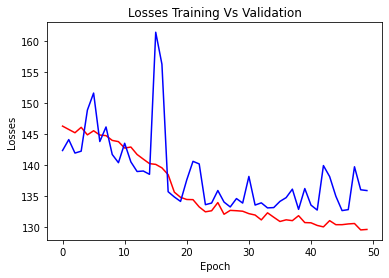

In [309]:
import matplotlib.pyplot as plt

plt.title('Losses Training Vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.plot(training_losses_history, '-r')
plt.plot(validation_losses_history, '-b')

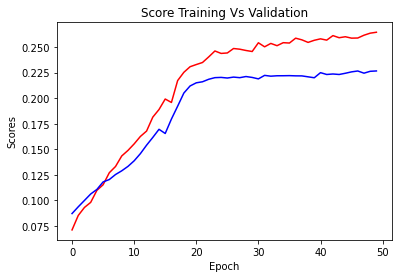

In [310]:
plt.title('Score Training Vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Scores')
plt.plot(training_score_history, '-r')
plt.plot(validation_score_history, '-b')

In [311]:
def predections(dataloader):
  test_tm_predictions = []
  net.eval()
  with torch.no_grad():
    for img in dataloader:
      img = img.to(device)
      tm_prediction = net(img)
      test_tm_predictions.append(tm_prediction.cpu().numpy())
  return [tm.squeeze().tolist() for tm in test_tm_predictions]

In [312]:
tm = predections(test_loader)

In [313]:
df = pd.DataFrame({"seq_id":test_seq_id, "tm":tm })
df

,seq_id,tm
0,31390,54.948174
1,31391,54.930817
2,31392,54.451313
3,31393,54.263195
4,31394,55.028179
...,...,...
2408,33798,54.660824
2409,33799,54.660824
2410,33800,54.658371
2411,33801,54.689381


In [314]:
df.describe()[['tm']].transpose()

,count,mean,std,min,25%,50%,75%,max
tm,2413.0,54.651118,0.419045,52.747105,54.536446,54.653217,54.769474,56.95203


In [316]:
df.to_csv("submission.csv", index=False)